# DCR Research - Assingment 3
Astronomy 499: (Winter 2022)

In [1]:
import numpy as np
import scipy.constants as const
import matplotlib
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.units import cds
cds.enable()
import pandas as pd

## From Previous Assignments 

In [2]:
latitude = -30.24463 * u.deg
longitude = -70.74942 * u.deg
altitude = 2647 * u.m
p0 = 101325 * u.Pa # sea level air presssure
g = const.g * (u.m/u.s**2)
R0 = 8.31447 * u.J/(u.mol*u.K) # gas constant
T0 = 19. * u.deg_C # typical sea level temperature
lapseRate = -6.5 * (u.deg_C/u.km) # typical rate of change of temperature with altitude
M = 0.0289644 * (u.kg/u.mol) # molar mass of dry air
humidity = 40. # typical humidity at many ovservatory sites

In [3]:
temperature = T0 + (lapseRate * altitude)
temperatureK = temperature.to(u.K, equivalencies = u.temperature())

pressure = (p0 * np.exp((-g * M * altitude) / (R0 * temperatureK))).to(u.Pa)

In [4]:
# calculating the water-vapor pressure (mm)
def power_vapor_pressure(temp, RH):
    t = temp.value
    x = np.log(RH/100)
    tdC_numerator = (((t + 238.3)*x) + (17.2694 * t))
    tdC_demoninator = ((t + 238.3) * (17.2694 - x)) - (17.2694 * t)
    tdC = (238.3 * (tdC_numerator/tdC_demoninator)) * u.deg_C
    t_dewpoint_C = tdC.value
    pressure = (4.50874 + (0.341724 * t_dewpoint_C) + (0.0106778 * t_dewpoint_C**2) + (0.184889e-3 * t_dewpoint_C**3) + (0.238294e-5 * t_dewpoint_C**4) + (0.203447e-7 * t_dewpoint_C**5)) * u.cds.mmHg
    return pressure

p_w = (power_vapor_pressure(temperature, humidity)).to(u.cds.mbar)
p_s = pressure.to(u.cds.mbar)
zin = 30 * u.deg

In [5]:
# Using Equations: 4, 5, 9, 10, 14, 15, 16, 18, 20, 21 + 2

def gammafunction(wavelength, Ps_in, Tinitial, Pw_in):
    T = Tinitial.to(u.K, equivalencies = u.temperature()).value
    sigma = 1/wavelength.to(u.um).value
    
    Ps = Ps_in.to(u.cds.mbar).value
    Pw = Pw_in.to(u.cds.mbar).value
    
    Ds = (1 + (Ps * (57.90e-8 - (9.3250e-4/T) + (0.25844/T**2)))) * (Ps/T)
    Dw = (1 + (Pw * (1 + 3.7e-4 * Pw) * (-2.37321e-3 + ((2.23366/T)-(710.792/T**2) + (7.75141e4/T**3))))) * (Pw/T)
    term_one = (2371.34 + (683939.7/(130 - sigma**2)) + (4547.3/(38.9 - sigma**2))) * Ds
    term_two = ((6487.31 + (58.058 * sigma**2) - (0.71150 * sigma**4) + (0.08851 * sigma**6))) * Dw
    n = ((term_one + term_two) / (1e8))
    return n

def calc_beta(tin):
    t = tin.value
    beta = 0.001254 * ((273.15 + t)/273.15)
    return beta

def calc_kappa(phi_degrees, height): # 10
    phi = phi_degrees.to(u.rad).value
    h = height.value
    kappa = 1 + (0.005302 * (np.sin(phi)**2)) - (0.00000583 * (np.sin(2 * phi)**2)) - (0.000000315 * h)
    return kappa
    
# Atmospheric refraction
def atm_refraction(wavelength, Ps, Tinitial, Pw, phi, h, z0):
    gamma = gammafunction(wavelength, Ps, Tinitial, Pw)
    beta = calc_beta(Tinitial)
    kappa = calc_kappa(phi , h)
    
    refraction = (kappa * gamma * (1 - beta) * np.tan(z0.to(u.rad))) - (kappa * gamma * (beta - (gamma / 2)) * (np.tan(z0.to(u.rad))**3))
    
    return refraction
    
    

In [6]:
rad2arcsec = (206265 * u.arcsec) # conversion between radians and arcseconds

In [7]:
# Import Data

# g-band
gband = pd.read_csv('total_g.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
gband_wavelength = np.array(gband[0]) * u.nm
gband_throughput = np.array(gband[1])

# i-band
iband = pd.read_csv('total_i.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
iband_wavelength = np.array(iband[0]) * u.nm
iband_throughput = np.array(iband[1])

# General
column_names = ['Wave', 'FluxD', 'e_FluxD'] #, 'None1', 'None2', 'None3', 'None4', 'None5', 'None6', 'None7', 'None8']
simulatedquasarspectrum = pd.read_csv('Vanden_Berk_quasars.txt', delimiter = " ", header=None, skipinitialspace = True, names = column_names, skiprows=23)
subsection = simulatedquasarspectrum
subsection = simulatedquasarspectrum.apply(pd.to_numeric, errors='coerce')

data = subsection[['Wave', 'FluxD', 'e_FluxD']]

In [8]:
# Wavelength
wavelength_or = np.array(subsection['Wave']) * u.Angstrom
wavelength_nm = (wavelength_or[23:]).to(u.nm)

# Relative Flux Density
relative_fluxdensity = subsection['FluxD'][23:]

In [9]:
# Defining Redshift Function
def redshift(z, spectrum_wavelength):
    redshiftspectrum = (1 + z) * spectrum_wavelength
    return redshiftspectrum

# Redshifts
spectra_obs = [wavelength_nm, redshift(1.0, wavelength_nm), redshift(1.5, wavelength_nm), redshift(2.0, wavelength_nm), redshift(2.5, wavelength_nm)]
redshifts = [1.0, 1.5, 2.0, 2.5]


In [10]:
# Calculate the effective wavelength

gWeightedWavelength = np.average(gband_wavelength[0:7755], weights = gband_throughput[0:7755])
iWeightedWavelength = np.average(iband_wavelength[0:7755], weights = iband_throughput[0:7755])


In [11]:
# Defining Subbands
def subbands(wavelength, throughput, number_bands):
    sum_ts = np.sum(throughput)
    cum_ts = np.cumsum(throughput)
    
    bounds = []
    for b in range(number_bands - 1):
        bound = ((1 + b) / number_bands) * sum_ts
        wlgth = np.interp(bound, cum_ts, wavelength)
        bounds.append(wlgth)
        
    return bounds

### G-Band

In [12]:
# G-Band Subband Boundaries
gwavelength_bounds = subbands(gband_wavelength, gband_throughput, 3)
gwavelength_bounds

throughput_threshold_g = max(gband_throughput)/100

# Defining G-Band Subbands
subband_g_1 = gband_wavelength.value < gwavelength_bounds[0]
subband_g_2 = (gband_wavelength.value > gwavelength_bounds[0]) & (gband_wavelength.value < gwavelength_bounds[1])
subband_g_3 = gband_wavelength.value > gwavelength_bounds[1]

g1 = gband_wavelength[subband_g_1]
g2 = gband_wavelength[subband_g_2]
g3 = gband_wavelength[subband_g_3]

# Defining G-Band Flux Subbands
f1_g = np.sum(gband_throughput[subband_g_1])
f2_g = np.sum(gband_throughput[subband_g_2])
f3_g = np.sum(gband_throughput[subband_g_3])

In [13]:
def subband_wavelengths(band_wavelength, band_throughput, subband_number=3, minwavelength = 100, maxwavelength = 10000):
    bounds = subbands(band_wavelength, band_throughput, subband_number)
    
    effective_wavelengths = []
    
    for b in range(subband_number):
        if b == 0:
            lowerbound = minwavelength
        else:
            lowerbound = bounds[b-1]
            
        if b == subband_number-1:
            upperbound = maxwavelength
            
        else:
            upperbound = bounds[b]
        
        subband = (band_wavelength.value > lowerbound) & (band_wavelength.value < upperbound) 
        
        effective_wavelength = np.average(band_wavelength[subband], weights = band_throughput[subband])
        effective_wavelengths.append(effective_wavelength)
        
    return effective_wavelengths
    
    

### I-Band

In [14]:
# I-Band Subband Boundaries
iwavelength_bounds = subbands(iband_wavelength, iband_throughput, 3)
iwavelength_bounds

throughput_threshold_i = max(iband_throughput)/100

# Defining I-Band Subbands
subband_i_1 = (iband_wavelength.value < iwavelength_bounds[0]) & (iband_throughput > throughput_threshold_i)
subband_i_2 = (iband_wavelength.value > iwavelength_bounds[0]) & (iband_wavelength.value < iwavelength_bounds[1])
subband_i_3 = (iband_wavelength.value > iwavelength_bounds[1]) & (iband_throughput > throughput_threshold_i)

i1 = iband_wavelength[subband_i_1]
i2 = iband_wavelength[subband_i_2]
i3 = iband_wavelength[subband_i_3]

# Defining I-Band Flux Subbands
f1_i = np.sum(iband_throughput[subband_i_1])
f2_i = np.sum(iband_throughput[subband_i_2])
f3_i = np.sum(iband_throughput[subband_i_3])

## Part 1: Measure the Spectrum of Simulated Quasars

### Part 1a: Calculate Sub-Bands

Take the three sub-bands you calculated in Winter assignment 2b, and calculate the effective wavelength of each (like what you did for the full band in assignment 1, 3b). For your quasars at redshifts 1.0, 1.5, 2.0, and 2.5 and g- and i-bands, plot (with a symbol) the expected flux in each sub-band on top of the high-resolution spectrum. This is very similar to assignment 1, 2b, but with the addition of using the effective wavelength of each sub-band. Normalize the y-axis by bandwidth, so that the high-resolution input spectrum and the coarse sub-band fluxes are comparable. See the attached image for a rough sketch of what this might look like.

In [15]:
# Calculate Effective Wavelength of Subbands

gWeightedWavelength = np.average(gband_wavelength[0:7755], weights = gband_throughput[0:7755])
print("The effective wavelength of the LSST g-band is {:.2f}.".format(gWeightedWavelength))

iWeightedWavelength = np.average(iband_wavelength[0:7755], weights = iband_throughput[0:7755])
print("The effective wavelength of the LSST i-band is {:.2f}.".format(iWeightedWavelength))

The effective wavelength of the LSST g-band is 480.00 nm.
The effective wavelength of the LSST i-band is 754.22 nm.


In [16]:
gWeightedWavelength

<Quantity 480.00048773 nm>

In [17]:
# G-Band
g1_effective = np.average(gband_wavelength[subband_g_1], weights = gband_throughput[subband_g_1])
g2_effective = np.average(gband_wavelength[subband_g_2], weights = gband_throughput[subband_g_2])
g3_effective = np.average(gband_wavelength[subband_g_3], weights = gband_throughput[subband_g_3])


g_effective = [g1_effective, g2_effective, g3_effective]

print(f"The effective wavelengths of g-subbands 1, 2, and 3 are: {g1_effective, g2_effective, g3_effective}.")


The effective wavelengths of g-subbands 1, 2, and 3 are: (<Quantity 429.82696496 nm>, <Quantity 480.9518105 nm>, <Quantity 529.08487633 nm>).


In [18]:
g1_effective

<Quantity 429.82696496 nm>

In [19]:
# I-Band
i1_effective = np.average(iband_wavelength[subband_i_1], weights = iband_throughput[subband_i_1])
i2_effective = np.average(iband_wavelength[subband_i_2], weights = iband_throughput[subband_i_2])
i3_effective = np.average(iband_wavelength[subband_i_3], weights = iband_throughput[subband_i_3])

print(f"The effective wavelengths of i-subbands 1, 2, and 3 are : {i1_effective, i2_effective, i3_effective}.")

The effective wavelengths of i-subbands 1, 2, and 3 are : (<Quantity 711.06379058 nm>, <Quantity 753.89535794 nm>, <Quantity 797.67294613 nm>).


In [20]:
len(subband_g_1)

8501

In [21]:
# defining f1, 2, 3 in condensed function

g_subbands = [subband_g_1, subband_g_2, subband_g_3]
i_subbands = [subband_i_1, subband_i_2, subband_i_3]

def subbandFlux(wavelength, band_throughput, subbands, throughput_threshold, spectra_obs):
    f_values = []
    for s in subbands:
        #band_tempthroughput = np.zeros_like(band_throughput)
        #band_tempthroughput = band_throughput[s]
        print(repr(spectra_obs))
        print(repr(wavelength))
        print(repr(band_throughput))
        print(repr(band_throughput[s]))
        print(repr(s))
        interpolate = np.interp(spectra_obs, wavelength, band_throughput[s])
        normalization = np.sum(interpolate > throughput_threshold)
        f_itemp = np.sum(interpolate * relative_fluxdensity)/normalization
        f_values.append(f_itemp)
    return f_values

# for g: throughput_threshold_g

    gband_tempthroughput = np.zeros_like(gband_throughput)
    gband_tempthroughput[subband_g_1] = gband_throughput[subband_g_1]
    interpolate = np.interp(s, gband_wavelength[0:7755], gband_tempthroughput[0:7755])
    normalization = np.sum(interpolate > throughput_threshold_g)
    f1_itempg = np.sum(interpolate * relative_fluxdensity)/normalization
    
    gband_tempthroughput = np.zeros_like(gband_throughput)
    gband_tempthroughput[subband_g_2] = gband_throughput[subband_g_2]
    interpolate = np.interp(s, gband_wavelength[0:7755], gband_tempthroughput[0:7755])
    normalization = np.sum(interpolate > throughput_threshold_g)
    f2_itempg = np.sum(interpolate * relative_fluxdensity)/normalization
    
    gband_tempthroughput = np.zeros_like(gband_throughput)
    gband_tempthroughput[subband_g_3] = gband_throughput[subband_g_3]
    interpolate = np.interp(s, gband_wavelength[0:7755], gband_tempthroughput[0:7755])
    normalization = np.sum(interpolate > throughput_threshold_g)
    f3_itempg = np.sum(interpolate * relative_fluxdensity)/normalization

In [22]:
gband_throughput[0:7755]

array([0., 0., 0., ..., 0., 0., 0.])

[<Quantity [ 82.35,  82.45,  82.55, ..., 855.25, 855.35, 855.45] nm>, <Quantity [ 164.7,  164.9,  165.1, ..., 1710.5, 1710.7, 1710.9] nm>, <Quantity [ 205.875,  206.125,  206.375, ..., 2138.125, 2138.375, 2138.625] nm>, <Quantity [ 247.05,  247.35,  247.65, ..., 2565.75, 2566.05, 2566.35] nm>, <Quantity [ 288.225,  288.575,  288.925, ..., 2993.375, 2993.725, 2994.075] nm>]
<Quantity [ 300. ,  300.1,  300.2, ..., 1075.2, 1075.3, 1075.4] nm>
array([0., 0., 0., ..., 0., 0., 0.])


IndexError: boolean index did not match indexed array along dimension 0; dimension is 7755 but corresponding boolean dimension is 8501

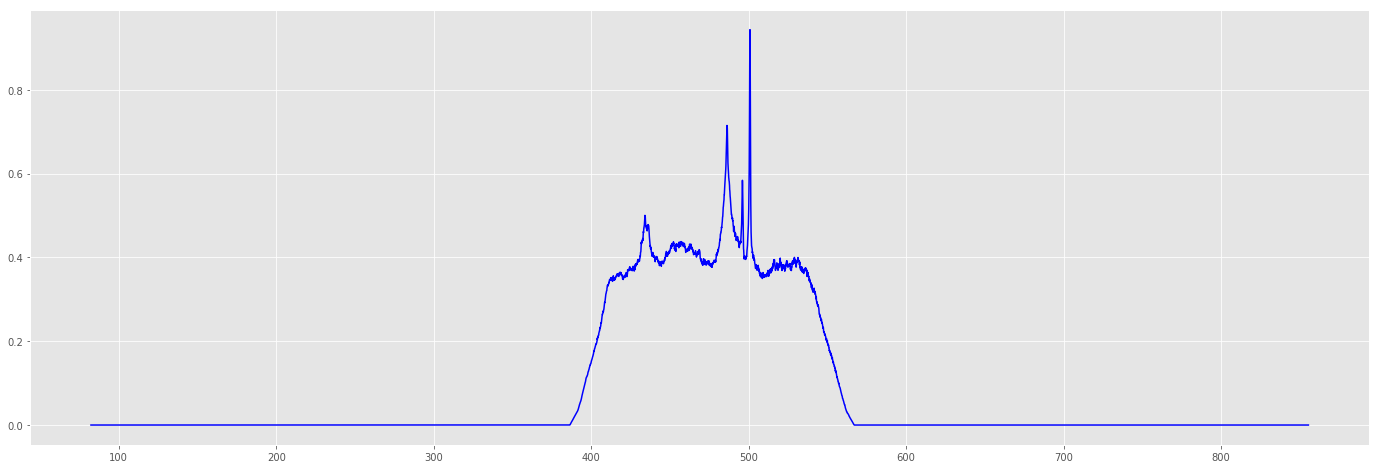

In [23]:
g_effectives = [g1_effective, g2_effective, g3_effective]

# G-Band Plots
plt.style.use('ggplot')
for z, s in zip(redshifts, spectra_obs):
    fig, ax = plt.subplots (1, 1, figsize = (24,8))
    interpolate = np.interp(s, gband_wavelength[0:7755], gband_throughput[0:7755])
    plt.plot(s, relative_fluxdensity * interpolate, label = 'Redshift z = {}'.format(z), color = 'b')
    
    #Fix f1, 2, 3 values to include actual spectrum
    f_values_g = subbandFlux(gband_wavelength[0:7755], gband_throughput[0:7755], g_subbands, throughput_threshold_g, spectra_obs)
    
    for i, g, f in enumerate(zip(g_effectives, f_values_g)):
        ax.plot(g, f, label = f'total flux for sub-band {i}', marker='+', color = 'r', markersize =16)
    
    #ax.plot(g1_effective, f1_itempg, label = 'total flux for sub-band 1', marker='+', color = 'r', markersize = 16)
    #ax.plot(g2_effective, f2_itempg, label = 'total flux for sub-band 2', marker='+', color = 'r', markersize = 16)
    #ax.plot(g3_effective, f3_itempg, label = 'total flux for sub-band 3', marker='+', color = 'r', markersize = 16)
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    plt.title('G-Band: Wavelength vs. Flux for z = {}'.format(z))
    plt.xlim(350, 600)
    plt.legend(loc = 0, shadow = True);

In [ ]:
# I-Band Plots
for z, s in zip(redshifts, spectra_obs):
    fig, ax = plt.subplots (1, 1, figsize = (24,8))
    interpolate = np.interp(s, iband_wavelength[0:7755], iband_throughput[0:7755])
    plt.plot(s, (relative_fluxdensity * interpolate), label = 'Redshift z = {}'.format(z), color = 'b')
    
    #Fix f1, 2, 3 values to include actual spectrum
    iband_tempthroughput = np.zeros_like(iband_throughput)
    iband_tempthroughput[subband_i_1] = iband_throughput[subband_i_1]
    interpolate = np.interp(s, iband_wavelength[0:7755], iband_tempthroughput[0:7755])
    normalization = np.sum(interpolate > throughput_threshold_i)
    f1_itemp = np.sum(interpolate * relative_fluxdensity)/normalization
    
    iband_tempthroughput = np.zeros_like(iband_throughput)
    iband_tempthroughput[subband_i_2] = iband_throughput[subband_i_2]
    interpolate = np.interp(s, iband_wavelength[0:7755], iband_tempthroughput[0:7755])
    normalization = np.sum(interpolate > throughput_threshold_i)
    f2_itemp = np.sum(interpolate * relative_fluxdensity)/normalization
    
    iband_tempthroughput = np.zeros_like(iband_throughput)
    iband_tempthroughput[subband_i_3] = iband_throughput[subband_i_3]
    interpolate = np.interp(s, iband_wavelength[0:7755], iband_tempthroughput[0:7755])
    normalization = np.sum(interpolate > throughput_threshold_i)
    f3_itemp = np.sum(interpolate * relative_fluxdensity)/normalization
    
    ax.plot(i1_effective, f1_itemp, label = 'total flux for sub-band 1', marker='+', color = 'r', markersize =16)
    ax.plot(i2_effective, f2_itemp, label = 'total flux for sub-band 2', marker='+', color = 'r', markersize =16)
    ax.plot(i3_effective, f3_itemp, label = 'total flux for sub-band 3', marker='+', color = 'r', markersize =16)
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    plt.title('I-Band: Wavelength vs. Flux for z = {}'.format(z))
    plt.xlim(670, 840)
    plt.legend(loc = 0, shadow = True);

### Part 1b: Calculate the DCR shifts

For each sub-band (of both g- and i-bands), calculate the DCR shift using the effective wavelength of the sub-band with the effective wavelength of the full band as the reference. Report the results in pixels, using the same 0.26 arcseconds/pixel plate scale you used in assignment 2.

In [ ]:
# define p_s, etc. inside function (don't pull in from above)

def DCRshift(subband_effWavelength, effectiveWavelength):
    grefraction_subband = atm_refraction(subband_effWavelength, p_s, temperature, p_w, latitude, altitude, zin)
    grefraction_effective = atm_refraction(effectiveWavelength, p_s, temperature, p_w, latitude, altitude, zin)
    g_difference =  (grefraction_subband - grefraction_effective) * rad2arcsec /0.26 # in pixels
    
    return g_difference.value

def difference(band_wavelength, band_throughput, subband, subband_number=3):
    overall_effective_wavelength = subband_wavelengths(band_wavelength, band_throughput, subband_number=1)
    subband_effective_wavelengths = subband_wavelengths(band_wavelength, band_throughput, subband_number=3)
    wavelengths = [wl.value for wl in subband_effective_wavelengths]
    
    difference = DCRshift(subband_effective_wavelengths[subband], overall_effective_wavelength[0])
    return difference



In [ ]:
def plot_subbands(band_wavelength, band_throughput, label_name, subband_number=3):
    
    overall_effective_wavelength = subband_wavelengths(band_wavelength, band_throughput, subband_number=1)
    subband_effective_wavelengths = subband_wavelengths(band_wavelength, band_throughput, subband_number=3)
    wavelengths = [wl.value for wl in subband_effective_wavelengths]
    
    differences = [DCRshift(subband,overall_effective_wavelength[0]) for subband in subband_effective_wavelengths]
    
    fig, ax = plt.subplots(1, 1, figsize = (24, 10))
    plt.plot(wavelengths, differences, label = label_name, color = 'b', marker='+', markersize = 14) #label = 'g-band', color = 'b', marker='+')
    ax.set_title('Refraction Difference (pixels) vs. Wavelength (nm)', color = 'k', fontsize = 16)
    ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k', fontsize = 16)
    ax.set_ylabel('Refraction Difference (pixels)', fontstyle = 'italic', color = 'k', fontsize = 16);

    ax.legend(loc = 0, shadow = True);

In [ ]:
plot_subbands(gband_wavelength, gband_throughput, 'g-band')

In [ ]:
# I-Subband

plot_subbands(iband_wavelength, iband_throughput, 'i-band')

### Part 1c: Fit a model

Take the simulated quasar image from assignment 2, 2a and find the best fit to this image using three sub-bands. To do this, model each sub-band as a 2D gaussian, shifted by the amounts you calculated in 1b above. The free parameters are the flux values of each sub-band image (so, a total of three numbers). There are many different ways you could do this fit, so pick one that makes sense to you and we can discuss the benefits and drawbacks of different methods at our meeting.

In [ ]:
import lmfit
from lmfit.lineshapes import gaussian2d

def modelFunction():
    
    model = lmfit.models.gaussian2d()
    params = model.guess(z, x, y)
    result = model.fit(z, x=x, y=y, params=params) #weights=)
    lmfit.report_fit(result)
    result.plot()

In [ ]:
fwhm_conversion = 2 * np.sqrt(2 * np.log(2))

# Creating 2D Gaussian Functions
def gaussianFunction(x_dimension = 32, y_dimension = 32, xcenter = 16, ycenter = 16, sigmax = (0.8/0.26)/fwhm_conversion, sigmay = (0.8/0.26)/fwhm_conversion):
    x = np.linspace(0, x_dimension-1, x_dimension)
    y = np.linspace(0, y_dimension-1, y_dimension)
    x, y = np.meshgrid(x, y)
    
    diffx = x - xcenter
    diffy = y - ycenter
    gaussian = np.exp(-((diffx**2/(2*sigmax**2))+(diffy**2/(2*sigmay**2))))
    
    return gaussian

# Defining X, Y & Gaussian Values
gaussian_2d = gaussianFunction()

# Plot of Gaussian Distribution
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize = (8, 24))
ax.imshow(gaussian_2d)
ax.set_title('2D Gaussian Distribution');

In [ ]:
def offset_2dgaussian(fwhm, flux, xoffset, yoffset):
    
    sigma = fwhm / 0.26/fwhm_conversion
    gaussian = gaussianFunction(x_dimension=32, y_dimension=32, xcenter=16, ycenter=16+yoffset, sigmax=sigma, sigmay=sigma)
    gaussian /= np.sum(gaussian)
    
    return gaussian*flux 

In [ ]:
def totalImage(band_wavelength, band_throughput, observed_spectra, relative_fluxdensity, WeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, fwhm, xcenter, ycenter):
    image_comp = np.zeros((32, 32), ) # float by default
    refractionindex_eff = atm_refraction(WeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin)
    yoffset_value = []
    
    fmin = max(band_throughput)*.01
    w_use = []
    for w,f in zip(band_wavelength, band_throughput):
        if f < fmin:
            continue
        w_use.append(w.value)
        
        # calculate flux - 2a
        interpolate = np.interp(w, observed_spectra, relative_fluxdensity)
        flux = f * interpolate
        
        # dcr shift - 3b
        refraction = atm_refraction(w, p_s, temperature, p_w, latitude, altitude, zin)
        yoffset = (refraction - refractionindex_eff)* rad2arcsec.value / 0.26
        yoffset_value.append(yoffset)
        xoffset = 0 / 0.26 # shift purely in the y-direction
        
        # creating gaussian
        newgaussian = offset_2dgaussian(fwhm, flux, xoffset, yoffset)
        image_comp += newgaussian.value

    fig, ax = plt.subplots(1, 1, figsize = (6, 6))
    im = ax.imshow(image_comp)
    fig.colorbar(im, orientation = 'vertical')
    ax.set_title('2D Offset Gaussian Distribution');  
    
    return w_use, yoffset_value, image_comp

In [ ]:
# G-Band Image
g_wls, gimage, gdistribution = totalImage(gband_wavelength, gband_throughput, spectra_obs[4], relative_fluxdensity, gWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, 0.8, 16, 16)



In [ ]:
# 3-subband gaussian images

# Gaussian Subband 1
gaussian_g1_shift = offset_2dgaussian(0.8, 1, 0, difference(gband_wavelength, gband_throughput, 0))
g1_mean = np.mean(gaussian_g1_shift)
print("Gaussian Subband 1 Mean: {}".format(g1_mean))
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
g1shift = ax.imshow(gaussian_g1_shift);
fig.colorbar(g1shift, orientation = 'vertical')
ax.set_title('Gaussian Subband 1 Distribution')

# Gaussian Subband 2
gaussian_g2_shift = offset_2dgaussian(0.8, 1, 0, difference(gband_wavelength, gband_throughput, 1))
g2_mean = np.mean(gaussian_g2_shift)
print("Gaussian Subband 2 Mean: {}".format(g2_mean))
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
g2shift = ax.imshow(gaussian_g2_shift);
fig.colorbar(g2shift, orientation = 'vertical')
ax.set_title('Gaussian Subband 2 Distribution')

# Gaussian Subband 3
gaussian_g3_shift = offset_2dgaussian(0.8, 1, 0, difference(gband_wavelength, gband_throughput, 2))
g3_mean = np.mean(gaussian_g3_shift)
print("Gaussian Subband 3 Mean: {}".format(g3_mean))
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
g3shift = ax.imshow(gaussian_g3_shift);
fig.colorbar(g3shift, orientation = 'vertical');
ax.set_title('Gaussian Subband 3 Distribution');

In [ ]:
# Calibrated Amplitude
totalmean = np.mean(gdistribution)

In [ ]:
# Differences

total_correctedmean = gdistribution * (g1_mean/totalmean) * 3

gdiff1 = total_correctedmean - gaussian_g2_shift - gaussian_g3_shift
gdiff2 = total_correctedmean - gaussian_g1_shift - gaussian_g3_shift
gdiff3 = total_correctedmean - gaussian_g1_shift - gaussian_g2_shift

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
totalimage_corrected = ax.imshow(total_correctedmean)
fig.colorbar(totalimage_corrected, orientation = 'vertical')
ax.set_title('Total Gaussian Distribution \n - Corrected Mean')

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
gaussian_subband1 = ax.imshow(gdiff1)
fig.colorbar(gaussian_subband1, orientation = 'vertical');
ax.set_title('Gaussian Subband 1 Distribution \n (Difference)');

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
gaussian_subband2 = ax.imshow(gdiff2)
fig.colorbar(gaussian_subband2, orientation = 'vertical');
ax.set_title('Gaussian Subband 2 Distribution \n (Difference)');

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
gaussian_subband3 = ax.imshow(gdiff3)
fig.colorbar(gaussian_subband3, orientation = 'vertical');
ax.set_title('Gaussian Subband 3 Distribution \n (Difference)');

In [ ]:
# Creating Mesh Grid for Gaussian Fit
x, y = gdiff1.shape
xmesh, ymesh = np.meshgrid(np.linspace(0, x-1, x), np.linspace(0, y-1, y))

In [ ]:
# Gaussian Fit Function

def gaussianfit(z, subband):
    x, y = z.shape
    xmesh, ymesh = np.meshgrid(np.linspace(0, x-1, x), np.linspace(0, y-1, y))
    
    zflat = z.flatten()
    xflat = xmesh.flatten()
    yflat = ymesh.flatten()
    print(len(zflat), len(yflat), len(xflat))
    
    model = lmfit.models.Gaussian2dModel()
    params = model.guess(zflat, xflat, yflat)
    result = model.fit(zflat, x=xflat, y=yflat, params=params)
    lmfit.report_fit(result)
    
    fig, ax = plt.subplots(1, 1, figsize = (6, 6))
    fit = model.func(xmesh, ymesh, **result.best_values)
    gaussian_fittedimage = ax.imshow(fit)
    fig.colorbar(gaussian_fittedimage, orientation = 'vertical');
    ax.set_title("Gaussian Subband {} Distribution \n (Fit)".format(subband));
    
    return result

In [ ]:
# Gaussian Fit Subband 1

fit1 = gaussianfit(gdiff1, "1")
fit2 = gaussianfit(gdiff2, "2")
fit3 = gaussianfit(gdiff3, "3")

In [ ]:
# Checking Fit Parameters - fit1?
fit1.params

In [ ]:
# Fit amplitude parameters
f1_amp = fit1.params["amplitude"] 
f2_amp = fit2.params["amplitude"]
f3_amp = fit3.params["amplitude"]

### Part 1d: Plot the measurements

Take the flux measurements from 1c, and plot them (with different symbols) on top of the plots from 1a above. As you did with the theoretical sub-band fluxes in 1a, normalize the y-axis so that the sub-band measurements, the theoretical sub-band fluxes, and the high-resolution spectra are comparable. It is probably cleanest if you duplicate the plots from 1a.

In [ ]:
# G-Band Plots:
plt.style.use('ggplot')
for z, s in zip(redshifts, spectra_obs):
    fig, ax = plt.subplots (1, 1, figsize = (24,8))
    interpolate = np.interp(s, gband_wavelength[0:7755], gband_throughput[0:7755])
    plt.plot(s, relative_fluxdensity * interpolate, label = 'Redshift z = {}'.format(z), color = 'b')
    
    #1a: Subband Wavelength vs Flux    
    ax.plot(g1_effective, f1_itempg, label = 'total flux for sub-band 1', marker='+', color = 'r', markersize = 16)
    ax.plot(g2_effective, f2_itempg, label = 'total flux for sub-band 2', marker='+', color = 'r', markersize = 16)
    ax.plot(g3_effective, f3_itempg, label = 'total flux for sub-band 3', marker='+', color = 'r', markersize = 16)
    
    #Fitted Flux Parameter
    ax.plot(g1_effective, f1_amp, marker = "*", color = 'g', markersize = 16)
    ax.plot(g2_effective, f2_amp, marker = "*", color = 'g', markersize = 16)
    ax.plot(g3_effective, f3_amp, marker = "*", color = 'g', markersize = 16)
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    plt.title('G-Band: Wavelength vs. Flux for z = {}'.format(z))
    plt.xlim(350, 600)
    plt.legend(loc = 0, shadow = True);

In [ ]:
# I-Band Plots
for z, s in zip(redshifts, spectra_obs):
    fig, ax = plt.subplots (1, 1, figsize = (24,8))
    interpolate = np.interp(s, iband_wavelength[0:7755], iband_throughput[0:7755])
    plt.plot(s, relative_fluxdensity * interpolate, label = 'Redshift z = {}'.format(z), color = 'b')
    
    #Fix f1, 2, 3 values to include actual spectrum
    iband_tempthroughput = np.zeros_like(iband_throughput)
    iband_tempthroughput[subband_i_1] = iband_throughput[subband_i_1]
    interpolate = np.interp(s, iband_wavelength[0:7755], iband_tempthroughput[0:7755])
    normalization = np.sum(interpolate > throughput_threshold_i)
    f1_itemp = np.sum(interpolate * relative_fluxdensity)/normalization
    
    iband_tempthroughput = np.zeros_like(iband_throughput)
    iband_tempthroughput[subband_i_2] = iband_throughput[subband_i_2]
    interpolate = np.interp(s, iband_wavelength[0:7755], iband_tempthroughput[0:7755])
    normalization = np.sum(interpolate > throughput_threshold_i)
    f2_itemp = np.sum(interpolate * relative_fluxdensity)/normalization
    
    iband_tempthroughput = np.zeros_like(iband_throughput)
    iband_tempthroughput[subband_i_3] = iband_throughput[subband_i_3]
    interpolate = np.interp(s, iband_wavelength[0:7755], iband_tempthroughput[0:7755])
    normalization = np.sum(interpolate > throughput_threshold_i)
    f3_itemp = np.sum(interpolate * relative_fluxdensity)/normalization
    
    #1a: Subband Wavelength vs Flux 
    ax.plot(i1_effective, f1_itemp, label = 'total flux for sub-band 1', marker='+', color = 'r', markersize =16)
    ax.plot(i2_effective, f2_itemp, label = 'total flux for sub-band 2', marker='+', color = 'r', markersize =16)
    ax.plot(i3_effective, f3_itemp, label = 'total flux for sub-band 3', marker='+', color = 'r', markersize =16)
    
    #Fitted Flux Parameter
    ax.plot(i1_effective, f1_amp, marker = "*", color = 'g', markersize = 16)
    ax.plot(i2_effective, f2_amp, marker = "*", color = 'g', markersize = 16)
    ax.plot(i3_effective, f3_amp, marker = "*", color = 'g', markersize = 16)
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    plt.title('I-Band: Wavelength vs. Flux for z = {}'.format(z))
    plt.xlim(670, 840)
    plt.legend(loc = 0, shadow = True);